## 1. Reading the pretrained Glove Embedding

In [1]:
from gensim.models import KeyedVectors

C:\Users\arvra\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
def prepend_slow(infile, outfile, line):
    """
    Slower way to prepend the line by re-creating the inputfile.
    """
    with open(infile, 'r',encoding = 'utf8') as fin:
        with open(outfile, 'w',encoding = 'utf8') as fout:
            fout.write(line + "\n")
            for line in fin:
                fout.write(line)

In [4]:
model = KeyedVectors.load_word2vec_format("glove.twitter.27B.200d_out.txt")

## 2. Reading the BESS Respone file

In [30]:
import pandas as pd
import numpy as np
import re

bess_tags = pd.read_csv('CBW_Bess_tags_final2.csv')
bess_tags.head()

,Content,Event,Type,para no,URI,author,biographyID,collectionID,personaName,title
0,after,name,stageOfLife,1.0,a001.bio04.bess.xml,Willis John Abbot,bio04,a001,Cleopatra,Cleopatra (B.C. 69-30): The World's Most Famou...
1,culmination,name,stageOfLife,1.0,a001.bio04.bess.xml,Willis John Abbot,bio04,a001,Cleopatra,Cleopatra (B.C. 69-30): The World's Most Famou...
2,middle,name,stageOfLife,2.0,a001.bio04.bess.xml,Willis John Abbot,bio04,a001,Cleopatra,Cleopatra (B.C. 69-30): The World's Most Famou...
3,middle,name,stageOfLife,3.0,a001.bio04.bess.xml,Willis John Abbot,bio04,a001,Cleopatra,Cleopatra (B.C. 69-30): The World's Most Famou...
4,middle,name,stageOfLife,4.0,a001.bio04.bess.xml,Willis John Abbot,bio04,a001,Cleopatra,Cleopatra (B.C. 69-30): The World's Most Famou...


In [21]:
all_bess = bess_tags['Content'].value_counts()[bess_tags['Content'].value_counts() > 3]

In [77]:
glove_embedding = {}
not_present = []

for each in all_bess.index:
    words = re.split('; |, | |-|_',each)
    all_words = [model[each.lower()] for each in words if each.lower() in model]
    
    if(len(all_words) > 0):
        glove_embedding[each] = np.mean(all_words,axis = 0)
        
    else:
        not_present.append(each)

In [82]:
all_bess_embeddings = pd.DataFrame(glove_embedding).T

## 3. Using clustering methods to group the values

In [83]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(all_bess_embeddings) 

In [96]:
all_bess_result = all_bess_embeddings.copy()
all_bess_result['class'] = kmeans.labels_

In [1]:
ss_distance_all = []
score_all = []
rng = range(10,500)
print("Trying to fit cluster values from k = 10 to k = 500 to identify the best k value")

for cluster in rng:
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(all_bess_embeddings)    
    #ss_distance_all.append(kmeans.inertia_)
    score_all.append(kmeans.score(all_bess_embeddings))

### 3.1 Plotting the Elbow diagram to find the optimal K-value

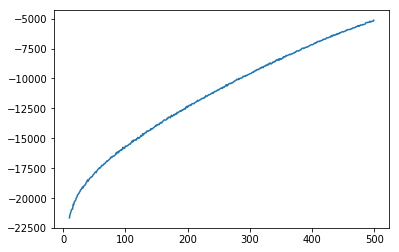

In [119]:
import pylab as pl
pl.plot(rng,score_all)

### 3.2 Using the optimal k value as 50, the clusters are formed

In [125]:
#### Using the optimal value of clusters k to build the final model
kmeans = KMeans(n_clusters= 50, random_state=0)
kmeans.fit(all_bess_embeddings)  


### Getting the cluster labels
all_bess_result = all_bess_embeddings.copy()
all_bess_result['class'] = kmeans.labels_

In [127]:
k_means_class = all_bess_result.sort_values(['class'])['class']

k_means_class.to_csv('Events.csv')